In [221]:
import sys
import tqdm
import sklearn
import numpy as np
import pandas as pd
import scipy
import copy
import random
import math
import torch
import torch.nn.functional as F
from load_dataset import load
from classifier import NeuralNetwork, LogisticRegression, SVM
from utils import *
from metrics import *  # include fairness and corresponding derivatives
from scipy import stats
from scipy.stats import rankdata
from sklearn import metrics, preprocessing
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import classification_report
from torch.autograd import grad
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Markdown, display
random.seed(1)
np.random.seed(1)
torch.manual_seed(1)

In [222]:
# ignore all the warnings
import warnings
warnings.filterwarnings('ignore') 

**Load Dataset**

In [223]:
dataset = 'compas'
X_train, X_test, y_train, y_test = load(dataset)

**Parametric Model**

In [224]:
# size=500
# X_train = X_train[0:size]
# y_train = y_train[0:size]

X_train_orig = copy.deepcopy(X_train)
X_test_orig = copy.deepcopy(X_test)

# Scale data: regularization penalty default: ‘l2’, ‘lbfgs’ solvers support only l2 penalties. 
# Regularization makes the predictor dependent on the scale of the features.
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

**Loss function** (Log loss for logistic regression)

In [225]:
# clf = NeuralNetwork()
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM()
num_params = len(convert_grad_to_ndarray(list(clf.parameters())))
if isinstance(clf, LogisticRegression) or isinstance(clf, NeuralNetwork):
#     loss_func = lambda model, x, y_true: logistic_loss_torch(model(torch.FloatTensor(x)),\
#                                                              torch.FloatTensor([y_true])) +\
#     model.C*torch.sqrt(torch.sum(convert_grad_to_tensor(list(clf.parameters()))**2))
    loss_func = logistic_loss_torch
elif isinstance(clf, SVM):
    loss_func = svm_loss_torch

**Influence of points computed using ground truth**

In [226]:
def ground_truth_influence(X_train, y_train, X_test, X_test_orig, y_test):
    clf.fit(X_train, y_train, verbose=True)
    y_pred = clf.predict_proba(X_test)
    spd_0 = computeFairness(y_pred, X_test_orig, y_test, 0)

    delta_spd = []
    for i in range(len(X_train)):
        X_removed = np.delete(X_train, i, 0)
        y_removed = y_train.drop(index=i, inplace=False)
        clf.fit(X_removed, y_removed)
        y_pred = clf.predict_proba(X_test)
        delta_spd_i = computeFairness(y_pred, X_test_orig, y_test, 0) - spd_0
        delta_spd.append(delta_spd_i)

    return delta_spd

**Compute Accuracy** 

In [227]:
def computeAccuracy(y_true, y_pred):
    return np.sum((y_pred>0.5) == y_true)/len(y_pred)

**First-order derivative of loss function at z with respect to model parameters**

In [228]:
def del_L_del_theta_i(model, x, y_true, retain_graph=False):
    loss = loss_func(model, x, y_true)
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(loss, w, create_graph=True, retain_graph=retain_graph)

**First-order derivative of $P(y \mid \textbf{x})$ with respect to model parameters**

In [229]:
def del_f_del_theta_i(model, x, retain_graph=False):
    w = [ p for p in model.parameters() if p.requires_grad ]
    return grad(model(torch.FloatTensor(x)), w, retain_graph=retain_graph)

**Stochastic estimation of Hessian vector product (involving del fairness): $H_{\theta}^{-1}v = H_{\theta}^{-1}\nabla_{\theta}f(z, \theta) = v + [I - \nabla_{\theta}^2L(z_{s_j}, \theta^*)]H_{\theta}^{-1}v$**

In [230]:
def hvp(y, w, v):
    ''' Multiply the Hessians of y and w by v.'''
    # First backprop
    first_grads = grad(y, w, retain_graph=True, create_graph=True)

    # Elementwise products
    elemwise_products = 0
    for grad_elem, v_elem in zip(convert_grad_to_tensor(first_grads), v):
        elemwise_products += torch.sum(grad_elem * v_elem)

    # Second backprop
    return_grads = grad(elemwise_products, w, create_graph=True)

    return return_grads

In [231]:
def hessian_one_point(model, x, y):
    x, y = torch.FloatTensor(x), torch.FloatTensor([y])
    loss = loss_func(model, x, y)
    params = [ p for p in model.parameters() if p.requires_grad ]
    first_grads = convert_grad_to_tensor(grad(loss, params, retain_graph=True, create_graph=True))
    hv = np.zeros((len(first_grads), len(first_grads)))
    for i in range(len(first_grads)):
        hv[i, :] = convert_grad_to_ndarray(grad(first_grads[i], params, create_graph=True)).ravel()
    return hv

In [232]:
# Compute multiplication of inverse hessian matrix and vector v
def s_test(model, xs, ys, v, damp=0.01, scale=25.0, r=-1, batch_size=-1, recursive=False, verbose=False):
    ''' Arguments:
        xs: list of data points
        ys: list of true labels corresponding to data points in xs
        damp: dampening factor
        scale: scaling factor
        r: number of iterations aka recursion depth
            should be enough so that the value stabilises.
        batch_size: number of instances in each batch in recursive approximation
        recursive: determine whether to recursively approximate hinv_v'''
    xs, ys = torch.FloatTensor(xs.copy()), torch.FloatTensor(ys.copy())
    n = len(xs)
    hinv_v = copy.deepcopy(v)
    if recursive:
        if verbose:
            print('Computing s_test...')
            tbar = tqdm.tqdm(total=r)
        if (batch_size == -1):  # default
            batch_size = 10
        if (r == -1):
            r = n // batch_size + 1
        sample = np.random.choice(range(n), r*batch_size, replace=True)
        for i in range(r):
            sample_idx = sample[i*batch_size:(i+1)*batch_size]
            x, y = xs[sample_idx], ys[sample_idx]
            loss = loss_func(model, x, y)
            params = [ p for p in model.parameters() if p.requires_grad ]
            hv = convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_v)))
            # Recursively caclulate h_estimate
            hinv_v = v + (1 - damp) * hinv_v - hv / scale
            if verbose:
                tbar.update(1)
    else:
        scale = 1.0
        hinv = np.linalg.pinv(np.sum(hessian_all_points, axis=0))
        hinv_v = np.matmul(hinv, v)

    return hinv_v / scale

**First-order influence computation**

In [233]:
def first_order_influence(del_L_del_theta, hinv_v, n):
    infs = []
    for i in range(n):
        inf = -np.dot(del_L_del_theta[i].transpose(), hinv_v)
        inf *= -1/n
        infs.append(inf)
    return infs

**Second-order influence computation for a group of points in subset U**

In [234]:
def second_order_influence(model, X_train, y_train, U, del_L_del_theta, r=-1, verbose=False):
    u = len(U)
    s = len(X_train)
    p = u/s
    c1 = (1 - 2*p)/(s * (1-p)**2)
    c2 = 1/((s * (1-p))**2)
    num_params = len(del_L_del_theta[0])
    del_L_del_theta_sum = np.sum([del_L_del_theta[i] for i in U], axis=0)
    hinv_del_L_del_theta= s_test(model, X_train, y_train, del_L_del_theta_sum)
    hessian_U_hinv_del_L_del_theta = np.zeros((num_params,))
    for i in range(u):
        idx = U[i]
        x, y = torch.FloatTensor(X_train[idx]), torch.FloatTensor([y_train[idx]])
        loss = loss_func(model, x, y)
        params = [ p for p in model.parameters() if p.requires_grad ]
        hessian_U_hinv_del_L_del_theta += convert_grad_to_ndarray(hvp(loss, params, torch.FloatTensor(hinv_del_L_del_theta)))

    term1 = c1 * hinv_del_L_del_theta
    term2 = c2 * s_test(model, X_train, y_train, hessian_U_hinv_del_L_del_theta)
    sum_term = term1 + term2
    return sum_term

**Metrics: Initial state**

In [235]:
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = NeuralNetwork()
# clf = SVM()

clf.fit(X_train, y_train)

y_pred_test = clf.predict_proba(X_test)
y_pred_train = clf.predict_proba(X_train)

spd_0 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
print("Initial statistical parity: ", spd_0)

tpr_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
print("Initial TPR parity: ", tpr_parity_0)

predictive_parity_0 = computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset)
print("Initial predictive parity: ", predictive_parity_0)

loss_0 = logistic_loss(y_test, y_pred_test)
print("Initial loss: ", loss_0)

accuracy_0 = computeAccuracy(y_test, y_pred_test)
print("Initial accuracy: ", accuracy_0)

Initial statistical parity:  0.11411776736053819
Initial TPR parity:  0.02712746391536691
Initial predictive parity:  0.026421868861987052
Initial loss:  0.22130841290778433
Initial accuracy:  0.9085239085239085


In [236]:
hessian_all_points = []
tbar = tqdm.tqdm(total=len(X_train))
for i in range(len(X_train)):
    hessian_all_points.append(hessian_one_point(clf, X_train[i], y_train[i])/len(X_train))
    tbar.update(1)







  0%|          | 0/5771 [00:00<?, ?it/s]





  0%|          | 12/5771 [00:00<00:48, 119.59it/s]





  0%|          | 24/5771 [00:00<00:48, 118.23it/s]





  1%|          | 33/5771 [00:00<00:53, 107.87it/s]





  1%|          | 45/5771 [00:00<00:52, 109.08it/s]





  1%|          | 58/5771 [00:00<00:52, 109.24it/s]





  1%|          | 71/5771 [00:00<00:50, 112.62it/s]





  1%|▏         | 83/5771 [00:00<00:50, 113.60it/s]





  2%|▏         | 97/5771 [00:00<00:47, 120.04it/s]





  2%|▏         | 112/5771 [00:00<00:44, 126.62it/s]





  2%|▏         | 125/5771 [00:01<00:47, 118.80it/s]





  2%|▏         | 137/5771 [00:01<00:47, 119.07it/s]





  3%|▎         | 149/5771 [00:01<00:48, 115.07it/s]





  3%|▎         | 162/5771 [00:01<00:48, 114.90it/s]





  3%|▎         | 174/5771 [00:01<00:48, 114.79it/s]





  3%|▎         | 186/5771 [00:01<00:52, 105.40it/s]





  3%|▎         | 199/5771 [00:01<00:50, 111.01it/s]





  4%|▎         | 211/5771 [00:01<00:49, 112.

 24%|██▎       | 1363/5771 [00:12<00:40, 109.76it/s]





 24%|██▍       | 1376/5771 [00:12<00:38, 114.22it/s]





 24%|██▍       | 1390/5771 [00:12<00:36, 119.39it/s]





 24%|██▍       | 1403/5771 [00:12<00:35, 121.94it/s]





 25%|██▍       | 1418/5771 [00:12<00:34, 127.92it/s]





 25%|██▍       | 1431/5771 [00:12<00:33, 128.26it/s]





 25%|██▌       | 1445/5771 [00:12<00:33, 130.67it/s]





 25%|██▌       | 1460/5771 [00:13<00:31, 135.07it/s]





 26%|██▌       | 1475/5771 [00:13<00:31, 137.62it/s]





 26%|██▌       | 1489/5771 [00:13<00:31, 137.46it/s]





 26%|██▌       | 1504/5771 [00:13<00:30, 139.00it/s]





 26%|██▋       | 1518/5771 [00:13<00:31, 137.10it/s]





 27%|██▋       | 1532/5771 [00:13<00:30, 137.09it/s]





 27%|██▋       | 1546/5771 [00:13<00:30, 137.73it/s]





 27%|██▋       | 1561/5771 [00:13<00:30, 140.02it/s]





 27%|██▋       | 1576/5771 [00:13<00:30, 138.71it/s]





 28%|██▊       | 1590/5771 [00:13<00:31, 132.16it/s]





 28%|██▊      

 50%|█████     | 2898/5771 [00:23<00:21, 130.92it/s]





 50%|█████     | 2912/5771 [00:23<00:21, 132.11it/s]





 51%|█████     | 2926/5771 [00:23<00:21, 133.37it/s]





 51%|█████     | 2940/5771 [00:23<00:21, 132.15it/s]





 51%|█████     | 2954/5771 [00:24<00:23, 121.28it/s]





 51%|█████▏    | 2967/5771 [00:24<00:23, 117.24it/s]





 52%|█████▏    | 2979/5771 [00:24<00:24, 112.99it/s]





 52%|█████▏    | 2991/5771 [00:24<00:26, 106.35it/s]





 52%|█████▏    | 3002/5771 [00:24<00:25, 106.79it/s]





 52%|█████▏    | 3014/5771 [00:24<00:25, 109.21it/s]





 52%|█████▏    | 3026/5771 [00:24<00:25, 106.83it/s]





 53%|█████▎    | 3037/5771 [00:24<00:29, 92.54it/s] 





 53%|█████▎    | 3049/5771 [00:25<00:27, 98.03it/s]





 53%|█████▎    | 3060/5771 [00:25<00:26, 100.46it/s]





 53%|█████▎    | 3071/5771 [00:25<00:28, 94.76it/s] 





 53%|█████▎    | 3081/5771 [00:25<00:28, 94.74it/s]





 54%|█████▎    | 3091/5771 [00:25<00:35, 74.79it/s]





 54%|█████▍    | 

 74%|███████▍  | 4288/5771 [00:36<00:11, 131.54it/s]





 75%|███████▍  | 4306/5771 [00:36<00:10, 141.59it/s]





 75%|███████▍  | 4324/5771 [00:36<00:09, 149.88it/s]





 75%|███████▌  | 4341/5771 [00:36<00:09, 154.35it/s]





 76%|███████▌  | 4359/5771 [00:36<00:08, 159.92it/s]





 76%|███████▌  | 4376/5771 [00:36<00:09, 146.94it/s]





 76%|███████▌  | 4394/5771 [00:36<00:08, 153.95it/s]





 76%|███████▋  | 4411/5771 [00:36<00:08, 157.70it/s]





 77%|███████▋  | 4429/5771 [00:37<00:08, 162.18it/s]





 77%|███████▋  | 4447/5771 [00:37<00:07, 165.91it/s]





 77%|███████▋  | 4465/5771 [00:37<00:07, 168.61it/s]





 78%|███████▊  | 4483/5771 [00:37<00:07, 169.53it/s]





 78%|███████▊  | 4501/5771 [00:37<00:07, 169.70it/s]





 78%|███████▊  | 4519/5771 [00:37<00:07, 157.19it/s]





 79%|███████▊  | 4535/5771 [00:37<00:10, 123.43it/s]





 79%|███████▉  | 4549/5771 [00:37<00:10, 121.27it/s]





 79%|███████▉  | 4563/5771 [00:38<00:09, 124.79it/s]





 79%|███████▉ 

**Pre-compute: (1) Hessian (2) del_L_del_theta for each training data point**

In [237]:
del_L_del_theta = []
for i in range(int(len(X_train))):
    del_L_del_theta.append(convert_grad_to_ndarray(del_L_del_theta_i(clf, X_train[i], y_train[i])))

*Select delta fairness function depending on selected metric*

In [238]:
metric = 0
if metric == 0:
    v1 = del_spd_del_theta(clf, X_test_orig, X_test, dataset)
elif metric == 1:
    v1 = del_tpr_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)
elif metric == 2:
    v1 = del_predictive_parity_del_theta(clf, X_test_orig, X_test, y_test, dataset)

In [239]:
hinv_v = s_test(clf, X_train, y_train, v1, verbose=False)

**First-order influence of each training data point**

In [240]:
infs_1 = first_order_influence(del_L_del_theta, hinv_v, len(X_train))

**Checking ground truth, first-order and second-order influences for a set**

In [241]:
metric = 0
if metric == 0:
    print("Statistical parity ")
elif metric == 1:
    print("True positive rate parity ")
elif metric == 2:
    print("Predictive parity")
    
active = 1
if active:
    if dataset == 'german':
        predicates = ['age']
    elif dataset == 'adult':
        predicates = ['gender_Male']
    elif dataset == 'compas':
        predicates = ['race']
    idx = X_train_orig.index 
    for pred in predicates:
        idx0 = X_train_orig[(X_train_orig[pred] == 1)].index 
        idx = idx.intersection(idx0)

    del_f_1 = 0
    for i in range(len(idx)):
        del_f_1 += infs_1[idx[i]]
    print("First-order influence: ", del_f_1)

    params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta)
    del_f_2 = np.dot(v1.transpose(), params_f_2)
    print("Second-order influence: ", del_f_2)
    
    print("#Rows removed: ", len(idx))
    print("#Rows left: ", len(X_train) - len(idx))
    X = np.delete(X_train, idx, 0)
    y = y_train.drop(index=idx, inplace=False)
    clf.fit(np.array(X), np.array(y))
    y_pred_test = clf.predict_proba(X_test)
    print("Ground truth influence of subset (on statistical parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset) - spd_0)
    print("Ground truth influence of subset (on tpr parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset) - tpr_parity_0)
    print("Ground truth influence of subset (on predictive parity): ", computeFairness(y_pred_test, X_test_orig, y_test, 2, dataset) - predictive_parity_0)
    
    spd_1 = computeFairness(y_pred_test, X_test_orig, y_test, 0, dataset)
    print("Ground truth statistical parity after removing subset: ", spd_1)
    
    tpr_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth tpr parity after removing subset: ", tpr_parity_1)

    predictive_parity_1 = computeFairness(y_pred_test, X_test_orig, y_test, 1, dataset)
    print("Ground truth predictive parity after removing subset: ", predictive_parity_1)

    loss_1 = logistic_loss(y_test, y_pred_test)
    print("Loss after removing subset: ", loss_1)

    accuracy_1 = computeAccuracy(y_test, y_pred_test)
    print("Accuracy after removing subset: ", accuracy_1)

Statistical parity 
First-order influence:  0.001017087187026287
Second-order influence:  0.002070834829749303
#Rows removed:  1959
#Rows left:  3812
Ground truth influence of subset (on statistical parity):  0.059572089267086126
Ground truth influence of subset (on tpr parity):  0.038646092660664544
Ground truth influence of subset (on predictive parity):  -0.09912676625844652
Ground truth statistical parity after removing subset:  0.17368985662762432
Ground truth tpr parity after removing subset:  0.06577355657603146
Ground truth predictive parity after removing subset:  0.06577355657603146
Loss after removing subset:  0.2437881525120729
Accuracy after removing subset:  0.9071379071379071


**Fairness: Ground-truth subset influence vs. computed subset influences: Random subset**

In [242]:
# print("Ground-truth subset, Add 1st-order inf individual, Second-order subset influence")
# sampleSize = int(.2 * len(X_train))
# for i in range(100):
#     idx = random.sample(range(1, len(X_train)), sampleSize) 
    
#     # Ground truth subset influence
#     X = np.delete(X_train, idx, 0)
#     y = y_train.drop(index=idx, inplace=False)
#     clf.fit(X, y, learning_rate=.05)
#     y_pred_test = clf.predict_proba(X_test)
#     inf_gt = computeFairness(y_pred_test, X_test_orig, y_test, 0) - spd_0

#     # First-order subset influence
#     del_f_1 = 0
#     for j in range(len(idx)):
#         del_f_1 += infs_1[idx[j]]
    
#     # Second-order subset influence
#     size_hvp = 1
#     params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta, r=5000)
#     del_f_2 = np.dot(v1.transpose(), params_f_2)

#     print(inf_gt, del_f_1, del_f_2, sep=", ")

**Fairness: Ground-truth subset influence vs. computed subset influences: Coherent subset** 

(by coherent, we mean group of data points that share some properties)

***NOTE:*** The retraining of the clf would cause the change in model parameters and thus lead to the change of gradients, so in this part, we first acquire all the first- and second-order influence functions together based on the original model. After all the influence functions are calculated, we retrain the model corresponding to different removed coherent subset of data and get the ground truth.

In [243]:
# Get the original model
clf = LogisticRegression(input_size=X_train.shape[-1])
# clf = SVM()
clf.fit(X_train, y_train)

In [244]:
attributes = []
attributeValues = []
first_order_influences = []
second_order_influences = []
fractionRows = []

# print("Attribute, Value, Ground-truth subset, Add 1st-order inf individual, \
# Second-order subset influence, %rowsRemoved, Accuracy")
clf.fit(X_train, y_train)
# continuous_cols = ['duration', 'credit_amt', 'install_rate', 'num_credits', 'residence']
v1_orig = v1
for col in X_train_orig.columns:
    if dataset == 'german':
        if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
            vals = [1]
        else:
            vals = X_train_orig[col].unique()
    elif dataset == 'adult':
        continuous_cols = ['age', 'education.num', 'hours',]
        if col in continuous_cols:
            vals = X_train_orig[col].unique()
        else:
            vals = [1]
    elif dataset == 'compas':
        vals = X_train_orig[col].unique()
    else:
        raise NotImplementedError
    for val in vals:
#         print(col, val, sep=": ")
        idx = X_train_orig[X_train_orig[col] == val].index 
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        if len(y.unique()) > 1:
            idx = X_train_orig[X_train_orig[col] == val].index 

            # First-order subset influence
            del_f_1 = 0            
            for i in range(len(idx)):
                del_f_1 += infs_1[idx[i]]

            # Second-order subset influence
            params_f_2 = second_order_influence(clf, X_train, y_train, idx, del_L_del_theta)
            del_f_2 = np.dot(v1.transpose(), params_f_2)

            attributes.append(col)
            attributeValues.append(val)
            first_order_influences.append(del_f_1)
            second_order_influences.append(del_f_2)
    #         gt_influences.append(inf_gt)
            fractionRows.append(len(idx)/len(X_train)*100)

    #         print(col, val, inf_gt, del_f_1, del_f_2, len(idx)/len(X_train), accuracy, sep=", ")







100%|██████████| 5771/5771 [01:00<00:00, 91.61it/s]

In [245]:
gt_influences = []
v1s = []
for col in X_train_orig.columns:
    if dataset == 'german':
        if "purpose" in col or "housing" in col: #dummy variables purpose=0 doesn't make sense
            vals = [1]
        else:
            vals = X_train_orig[col].unique()
    elif dataset == 'adult':
        continuous_cols = ['age', 'education.num', 'hours',]
        if col in continuous_cols:
            vals = X_train_orig[col].unique()
        else:
            vals = [1]
    elif dataset == 'compas':
        vals = X_train_orig[col].unique()
    else:
        raise NotImplementedError
    for val in vals:
        idx = X_train_orig[X_train_orig[col] == val].index 
        X = np.delete(X_train, idx, 0)
        y = y_train.drop(index=idx, inplace=False)
        inf_gt = 0
        if len(y.unique()) > 1:
            # Ground truth subset influence
            clf.fit(np.array(X), np.array(y))
            y_pred = clf.predict_proba(np.array(X_test))
            if metric == 0:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 0, dataset) - spd_0
            elif metric == 1:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 1, dataset) - tpr_parity_0
            elif metric == 2:
                inf_gt = computeFairness(y_pred, X_test_orig, y_test, 2, dataset) - predictive_parity_0
            accuracy = computeAccuracy(y_test, y_pred)
            gt_influences.append(inf_gt)
            v1s.append(del_spd_del_theta(clf, X_test_orig, X_test, dataset))  # here, v1 corresponds to the metric spd

In [246]:
def compute_cosine_theta(vec1: np.ndarray, vec2: np.ndarray):
    """
        Compute cosine of the angle between two vectors 
    """
    vec1 = vec1.squeeze()
    vec2 = vec2.squeeze()
    assert vec1.shape == vec2.shape
    vec1 /= np.sqrt(np.sum(vec1**2))
    vec2 /= np.sqrt(np.sum(vec2**2))
    return np.dot(vec1.T, vec2)

In [247]:
def compute_theta(vec1: np.ndarray, vec2: np.ndarray, measure='radian'):
    """
        Compute the angle between two vectors (angle/radian measure)
    """
    cos = compute_cosine_theta(vec1, vec2)
    theta = np.arccos(cos)
    if measure == 'angle':
        theta = theta / np.pi * 180
    return theta

In [248]:
cos_thetas = []
thetas = []
grad_change_scales = []
for vec in v1s:
    cos_thetas.append(compute_cosine_theta(v1_orig, vec))
    thetas.append(compute_theta(v1_orig, vec, measure='angle'))
    grad_change_scales.append(np.sqrt(np.sum((vec-v1_orig)**2)))

In [249]:
expl = [attributes, attributeValues, first_order_influences, second_order_influences, gt_influences, fractionRows, thetas, grad_change_scales]
expl = (np.array(expl).T).tolist()

explanations = pd.DataFrame(expl, columns=["attributes", "attributeValues", "first_order_influences", "second_order_influences", "gt_influences", "fractionRows", "gradient_angles", "grad_change_scales"])

In [250]:
explanations.sort_values(by=['second_order_influences'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows,gradient_angles,grad_change_scales
0,event,1,1.726307022711254e-05,5.5280647446130995e-05,-0.016862852214931418,38.000346560388145,6.137317776466377,0.10706519955872652
2,priors_count,0,0.0037443595349798183,0.029605133382554563,0.02388243262246753,78.79050424536476,7.5028950551273335,0.1308566784776852
8,juv_misd_count,0,-0.0010172256211843265,0.02450235447974003,0.00030040801400949,94.42037775082308,3.431795926785675,0.05988718523740131
15,age_cat,1,0.004021952390490406,0.010851510100772442,0.011186869484140882,57.303760180211405,2.726516260634218,0.047582195996767905
5,juv_other_count,0,0.0028892062323075092,0.009549332309492828,0.04261291353564278,92.72223184889967,9.291028339141583,0.16198142457585074
16,age_cat,2,0.004551656403507557,0.005927047183480899,0.006194921762235572,21.5387281233755,2.335564959908453,0.04076047624522225
22,score_text,1,0.0023302392119447643,0.003349191325747017,0.0033279451033013108,26.598509790330965,1.4137271328042929,0.02467356727869247
19,sex,0,0.002576874047149023,0.003146405300543755,0.0055897392225978115,19.078149367527292,2.747117335493059,0.047941650039777385
14,race,1,0.001017087187026287,0.002070834829749303,0.059572089267086126,33.94559001906082,30.913974070764503,0.5330297725119013
9,juv_misd_count,1,0.0017540809483942582,0.0020097313065231665,0.0020985975693885717,3.8641483278461273,0.446202750555687,0.007787687449005815


In [251]:
explanations.sort_values(by=['gt_influences'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows,gradient_angles,grad_change_scales
14,race,1,0.001017087187026287,0.002070834829749303,0.059572089267086126,33.94559001906082,30.913974070764503,0.5330297725119013
5,juv_other_count,0,0.0028892062323075092,0.009549332309492828,0.04261291353564278,92.72223184889967,9.291028339141583,0.16198142457585074
2,priors_count,0,0.0037443595349798183,0.029605133382554563,0.02388243262246753,78.79050424536476,7.5028950551273335,0.1308566784776852
15,age_cat,1,0.004021952390490406,0.010851510100772442,0.011186869484140882,57.303760180211405,2.726516260634218,0.047582195996767905
16,age_cat,2,0.004551656403507557,0.005927047183480899,0.006194921762235572,21.5387281233755,2.335564959908453,0.04076047624522225
19,sex,0,0.002576874047149023,0.003146405300543755,0.0055897392225978115,19.078149367527292,2.747117335493059,0.047941650039777385
22,score_text,1,0.0023302392119447643,0.003349191325747017,0.0033279451033013108,26.598509790330965,1.4137271328042929,0.02467356727869247
20,score_text,2,0.000880192252832534,0.0015599509327225254,0.0025039435655218045,19.80592618263732,1.0176702193741014,0.017761462552595354
9,juv_misd_count,1,0.0017540809483942582,0.0020097313065231665,0.0020985975693885717,3.8641483278461273,0.446202750555687,0.007787687449005815
3,priors_count,2,0.0008138666763433896,0.0009063083364237348,0.0009619388408056428,3.8468203084387453,0.16142114103373115,0.002817329461612478


In [252]:
explanations.sort_values(by=['fractionRows'], ascending=False).head(10)

,attributes,attributeValues,first_order_influences,second_order_influences,gt_influences,fractionRows,gradient_angles,grad_change_scales
10,juv_fel_count,0,-0.0009378621964126579,-0.021487146666836744,-0.03065034684637813,96.27447582741293,6.087390677032536,0.10619504664034433
8,juv_misd_count,0,-0.0010172256211843265,0.02450235447974003,0.00030040801400949,94.42037775082308,3.431795926785675,0.05988718523740131
5,juv_other_count,0,0.0028892062323075092,0.009549332309492828,0.04261291353564278,92.72223184889967,9.291028339141583,0.16198142457585074
18,sex,1,-0.0025917234590236457,-0.014935734951197273,-0.018358645865293843,80.92185063247271,7.98660834329032,0.13927978738510188
2,priors_count,0,0.0037443595349798183,0.029605133382554563,0.02388243262246753,78.79050424536476,7.5028950551273335,0.1308566784776852
13,race,0,-0.001031936598900919,-0.003244374416816702,-0.060858479511514796,66.05440998093918,21.052918790598373,0.3653791533333204
15,age_cat,1,0.004021952390490406,0.010851510100772442,0.011186869484140882,57.303760180211405,2.726516260634218,0.047582195996767905
21,score_text,0,-0.0032252808766519074,-0.005893628211490623,-0.0072087933597191345,53.595564027031706,2.322451521412047,0.04053165083734566
6,juv_other_count,1,-0.0008500322070357865,-0.0009786057907370143,-0.0010630187380707978,5.0424536475480854,0.770285448058678,0.013443916003499366
0,event,1,1.726307022711254e-05,5.5280647446130995e-05,-0.016862852214931418,38.000346560388145,6.137317776466377,0.10706519955872652


In [253]:
import scipy.stats as ss
explanations["gt_rank"] = len(explanations) - ss.rankdata(explanations["gt_influences"])
explanations["so_rank"] = len(explanations) - ss.rankdata(explanations["second_order_influences"])

In [254]:
stats.kendalltau(explanations["gt_rank"], explanations["so_rank"])

KendalltauResult(correlation=0.6679841897233202, pvalue=8.068163765895846e-06)

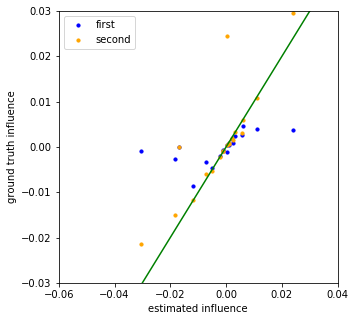

In [272]:
plt.figure(figsize=(5,5))
xs = (np.arange(30)-15)/15*0.1
ys = xs
plt.xlim(-0.06, 0.04)
plt.ylim(-0.03, 0.03)
plt.plot(xs, ys, 'g')
plt.scatter(gt_influences, first_order_influences, s=10, c='blue', label='first')
plt.scatter(gt_influences, second_order_influences, s=10, c='orange', label='second')
plt.xlabel('estimated influence')
plt.ylabel('ground truth influence')
plt.legend()

In [256]:
# bucket_num = 10
fractionRows = np.array(fractionRows)
gt_influences = np.array(gt_influences)
first_order_influences = np.array(first_order_influences)
second_order_influences = np.array(second_order_influences)
corr_first_gt_ls = []
corr_second_gt_ls = []
for bucket_id in range(10):
    is_in_bucket = np.logical_and(fractionRows>=bucket_id*10, fractionRows<(bucket_id+1)*10)
    corr_first_gt = np.corrcoef([gt_influences[is_in_bucket], first_order_influences[is_in_bucket]])[0][1]
    if np.isnan(corr_first_gt):
        corr_first_gt = 0
    corr_second_gt = np.corrcoef([gt_influences[is_in_bucket], second_order_influences[is_in_bucket]])[0][1]
    if np.isnan(corr_second_gt):
        corr_second_gt = 0
    corr_first_gt_ls.append(corr_first_gt)
    corr_second_gt_ls.append(corr_second_gt)

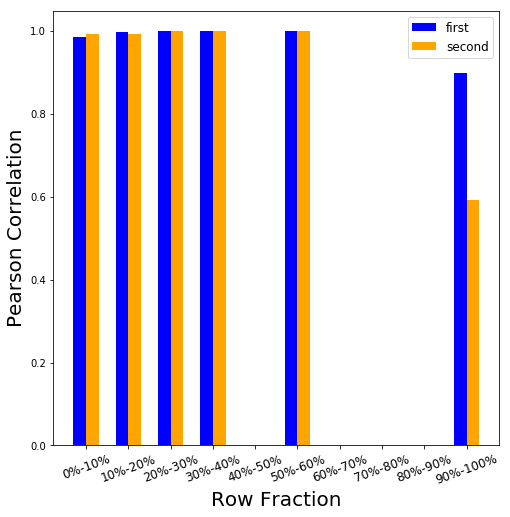

In [257]:
plt.figure(figsize=(8,8))
bar_width=0.3
tick_label=[f'{i*10}%-{(i+1)*10}%' for i in range(10)]
plt.bar(np.arange(10), corr_first_gt_ls, bar_width, color='blue', label='first')
plt.bar(np.arange(10)+bar_width, corr_second_gt_ls, bar_width, color='orange', label='second')
plt.legend(fontsize=12)
plt.xticks(np.arange(10)+bar_width/2, tick_label, rotation=20, fontsize=12)
plt.xlabel('Row Fraction', fontsize=20)
plt.ylabel('Pearson Correlation', fontsize=20)
plt.show()

In [258]:
# overall correlation
np.corrcoef([gt_influences, first_order_influences])[0][1], np.corrcoef([gt_influences, second_order_influences])[0][1]

(0.4411629235321781, 0.5033149386886179)

less than 2 coherent subsets correspond to the bracket 50%-60%, therefore cannot compute corrsponding pearson correlation

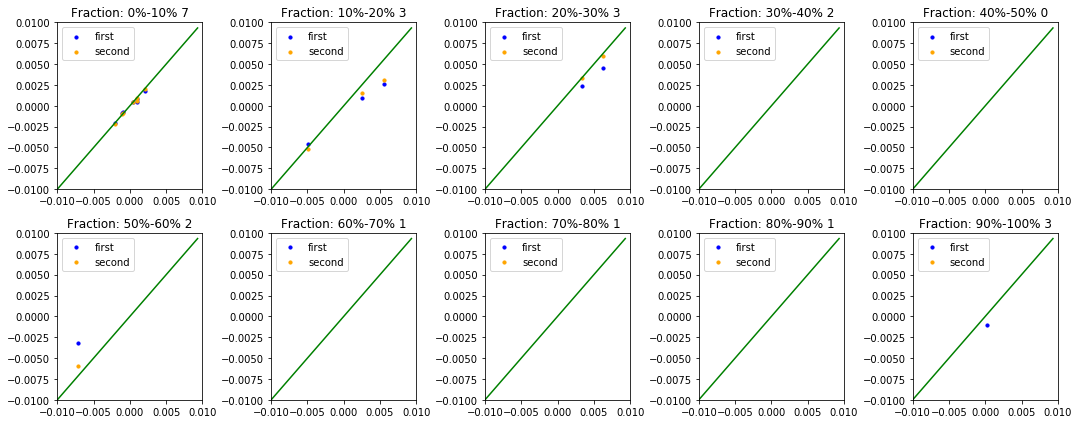

In [267]:
lim = 0.01
plt.figure(figsize=(15, 6))
for bucket_id in range(10):
    plt.subplot(2, 5, bucket_id+1)
    is_in_bucket = np.logical_and(fractionRows>=bucket_id*10, fractionRows<(bucket_id+1)*10)
    xs = (np.arange(30)-15)/15*lim
    ys = xs
    plt.xlim(-lim, lim)
    plt.ylim(-lim, lim)
    plt.plot(xs, ys, 'g')
    plt.scatter(gt_influences[is_in_bucket], first_order_influences[is_in_bucket], s=10, c='blue', label='first')
    plt.scatter(gt_influences[is_in_bucket], second_order_influences[is_in_bucket], s=10, c='orange', label='second')
    plt.legend()
    plt.title(f'Fraction: {bucket_id*10}%-{(bucket_id+1)*10}% {np.sum(is_in_bucket)}')
plt.tight_layout()
plt.show()

For buckets which include only small num of coherent subsets (many of them corresponds to high row fraction), the pearson correlation can be less meaningful. However, from the scatter plots above, we can see that the estimation of influence function tends to be more accurate when the row fractions are relatively low, meanwhile, low row fraction leads to low overall influence (change of metrics caused by removing the subset) of coherent subsets.